In [37]:
import pandas as pd
from pandas_datareader import data as pdr

# There is an API issue getting yahoo finance data. This is a temporary fix
import fix_yahoo_finance as yf
yf.pdr_override()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

import numpy as np

Populating the interactive namespace from numpy and matplotlib


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 23:06:08.139577. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [21]:
start = datetime.datetime(2016,6,30)
end = datetime.date.today()

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:31:20.689556. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [22]:
tesla = pdr.get_data_yahoo('TSLA', start = start, end = end)

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:31:30.124549. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[*********************100%***********************]  1 of 1 downloaded

In [23]:
tesla.head()

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:31:33.329170. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-06-30,212.970001,213.500000,209.020004,212.279999,212.279999,4843100
2016-07-01,206.139999,218.240005,206.000000,216.500000,216.500000,5400000
2016-07-05,209.729996,214.539993,208.000000,213.979996,213.979996,5175300
2016-07-06,210.000000,215.229996,209.000000,214.440002,214.440002,4919900
2016-07-07,213.100006,218.119995,213.009995,215.940002,215.940002,3612000


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:31:37.575858. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


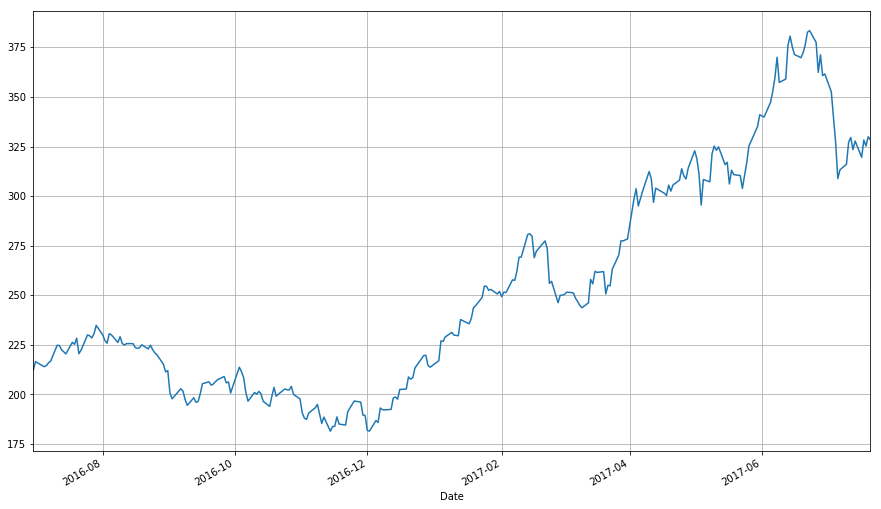

In [24]:
tesla['Adj Close'].plot(grid = True)

In [19]:
# A function to create a candle sticks stock chart showing all 
# open, high, low and close prices on one chart.  

from matplotlib.dates import DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
 
def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)    # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')  # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
 
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
 
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
 
    plt.show()
 


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:19:17.422523. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:31:56.772281. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


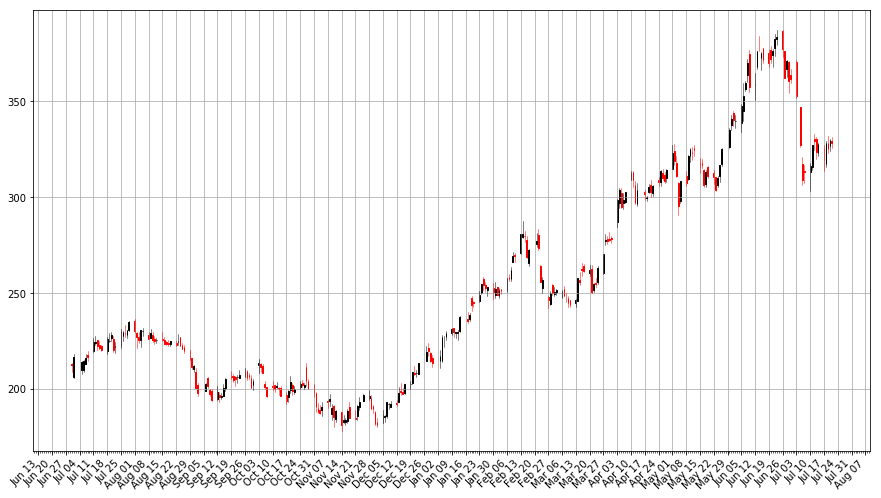

In [25]:
pandas_candlestick_ohlc(tesla)

# A black candlestick:  closing price was higher than open (a gain)
# A red candelstick:  open price was higher than closing (a loss)

In [30]:
microsoft = pdr.get_data_yahoo('MSFT', start = start, end = end)
google = pdr.get_data_yahoo('GOOG', start = start, end = end)
amazon = pdr.get_data_yahoo('AMZN', start = start, end = end)
ibm = pdr.get_data_yahoo('IBM', start = start, end = end)
apple = pdr.get_data_yahoo('AAPL', start = start, end = end)

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:39:12.183014. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[*********************100%***********************]  1 of 1 downloaded

In [31]:
tech_stocks = pd.DataFrame({'MSFT': microsoft['Adj Close'],
                           'GOOG': google['Adj Close'],
                           'AMZN': amazon['Adj Close'],
                           'IBM': ibm['Adj Close'],
                           'AAPL': apple['Adj Close']})
tech_stocks.head()

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:39:43.251828. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,AAPL,AMZN,GOOG,IBM,MSFT
Date,,,,,
2016-06-30,93.803650,715.619995,692.099976,146.526199,49.921288
2016-07-01,94.088203,725.679993,699.210022,147.076462,49.911530
2016-07-05,93.205109,728.099976,694.950012,146.429642,49.921288
2016-07-06,93.734970,737.609985,697.770020,147.095749,50.126163
2016-07-07,94.137268,736.570007,695.359985,147.317810,50.126163


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 18:39:48.926497. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


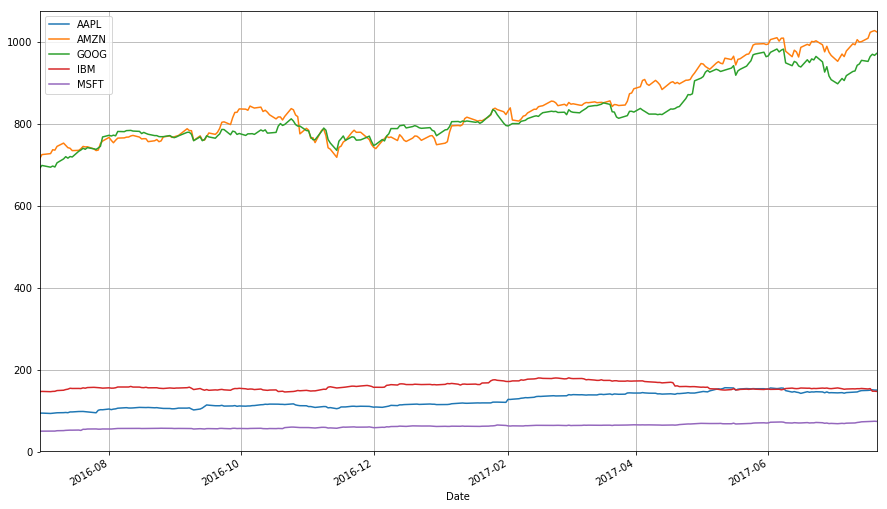

In [32]:
tech_stocks.plot(grid = True)

#### Both Amazon and Google are more expensive, making them more difficult to purchase. This affects not only their volatility but also the ability for trading. The above chart make IBM, Microsoft, and Apple appear less volatile than they turely are. One solution is to have two y-axis using secondary_y. This will  put all stocks on the same scale. 

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 22:53:12.276604. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


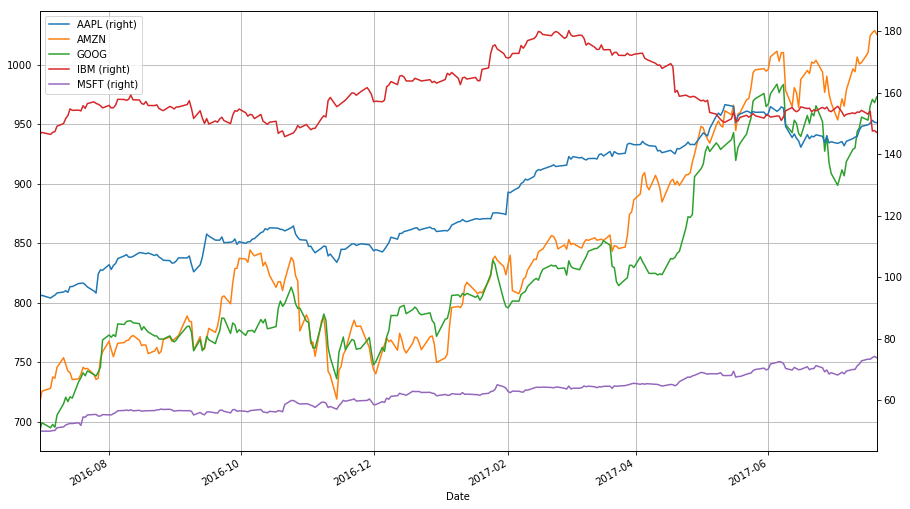

In [34]:
tech_stocks.plot(secondary_y= ['IBM', 'MSFT', 'AAPL'], grid = True)

#### The better solution is to plot the stock returns. This involves transforming the data into something more useful. 
#### One transformation would be to consider the stock's return since the beginning of the period of interest. In other words, we plot:

return (t, 0) = price (t)/ price (0)

In [35]:
stock_return = tech_stocks.apply(lambda x: x/x[0])
stock_return.head()

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 22:59:42.506209. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,AAPL,AMZN,GOOG,IBM,MSFT
Date,,,,,
2016-06-30,1.000000,1.000000,1.000000,1.000000,1.000000
2016-07-01,1.003033,1.014058,1.010273,1.003755,0.999805
2016-07-05,0.993619,1.017439,1.004118,0.999341,1.000000
2016-07-06,0.999268,1.030729,1.008193,1.003887,1.004104
2016-07-07,1.003557,1.029275,1.004710,1.005403,1.004104


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 23:00:40.445834. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


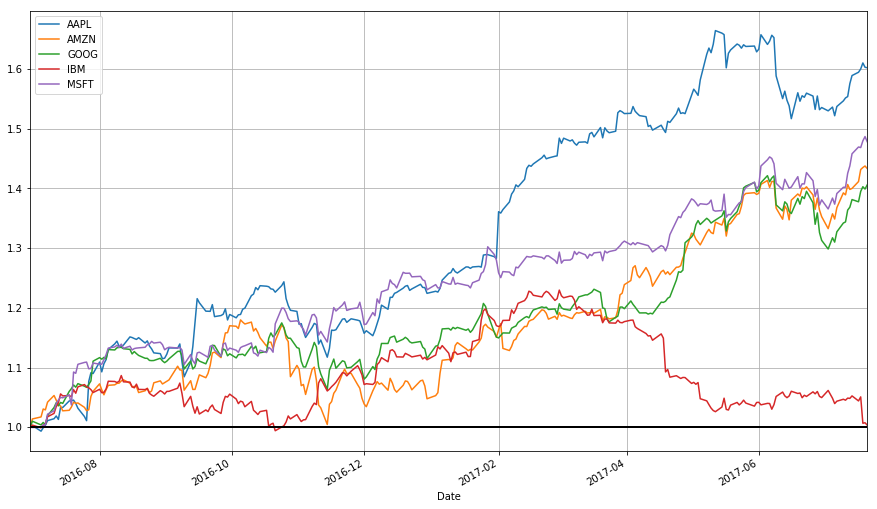

In [36]:
stock_return.plot(grid = True).axhline(y = 1, color = 'black', lw = 2)

#### This is a much more useful plot. We now can see how profitable each stcok was since the beginning of the period. Furthermore, we see that most stocks are highly correlated. They generally move in the same direction except IBM. 

#### Another way to look at is to model the growth of a stock with log differences. 

change(t) = log(price(t)) - log(price(t-1))

In [39]:
stock_change = tech_stocks.apply(lambda x: np.log(x) - np.log(x.shift(1)))
#shift moves dates back to 1

stock_change.head()

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 23:10:16.273096. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


,AAPL,AMZN,GOOG,IBM,MSFT
Date,,,,,
2016-06-30,NaN,NaN,NaN,NaN,NaN
2016-07-01,0.003029,0.013960,0.010221,0.003748,-0.000195
2016-07-05,-0.009430,0.003329,-0.006111,-0.004408,0.000195
2016-07-06,0.005669,0.012977,0.004050,0.004539,0.004096
2016-07-07,0.004283,-0.001411,-0.003460,0.001508,0.000000


/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 23:11:12.548482. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


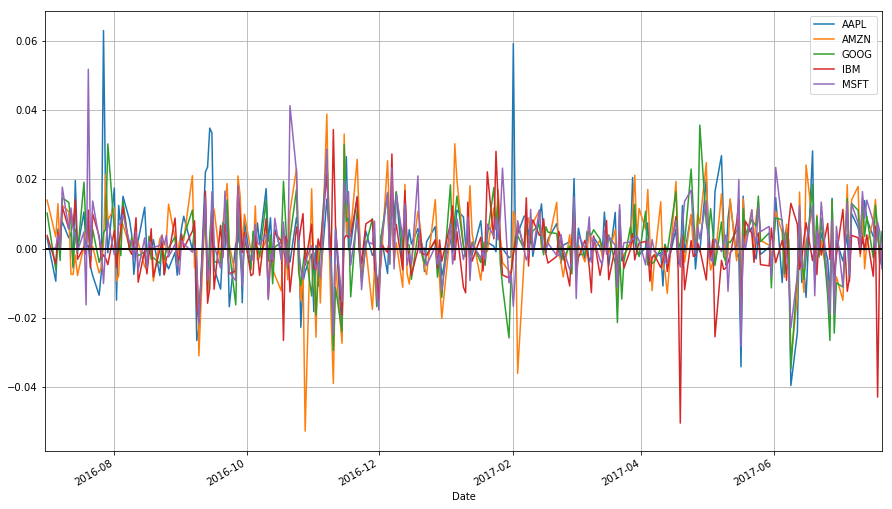

In [40]:
stock_change.plot(grid = True).axhline(y = 0, color = 'black', lw = 2)

# Moving Averages

#### Moving averages allow us to find trends in stocks. 
#### Moving averages smooth a series and helps identify trends. 
MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i} latex

The large q is, the lass responsive a moving average process is to short-term fluctuations in the series x_t. Fast moving averages have smaller q and more closely follow the stock. While slow moving averages have larger q, resulting in them responding less to the flucuations of the stock and being more stable. 

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-22 23:22:29.541151. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


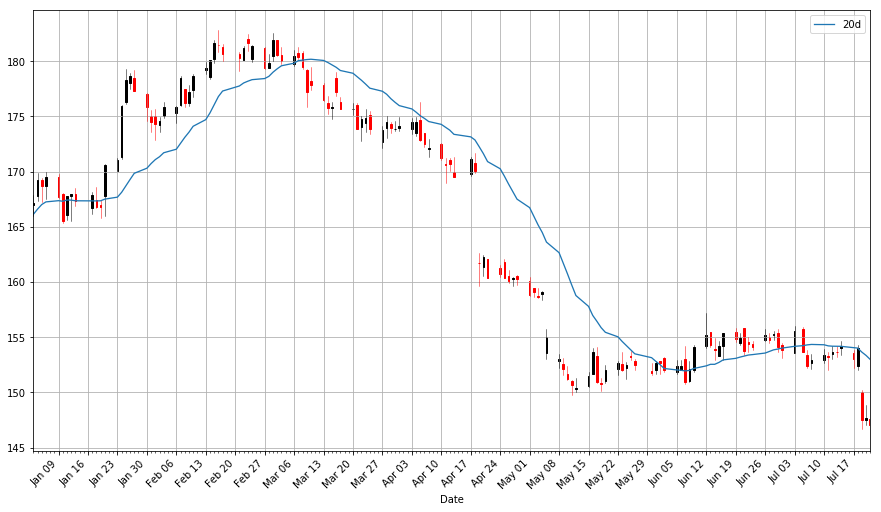

In [41]:
ibm['20d'] = np.round(ibm['Close'].rolling(window = 20, center = False).mean(), 2)
pandas_candlestick_ohlc(ibm.loc['2017-01-01': '2017-07-21', :], otherseries = '20d')

/Users/connie/anaconda/envs/Connie_python2/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-07-23 10:16:31.911978. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


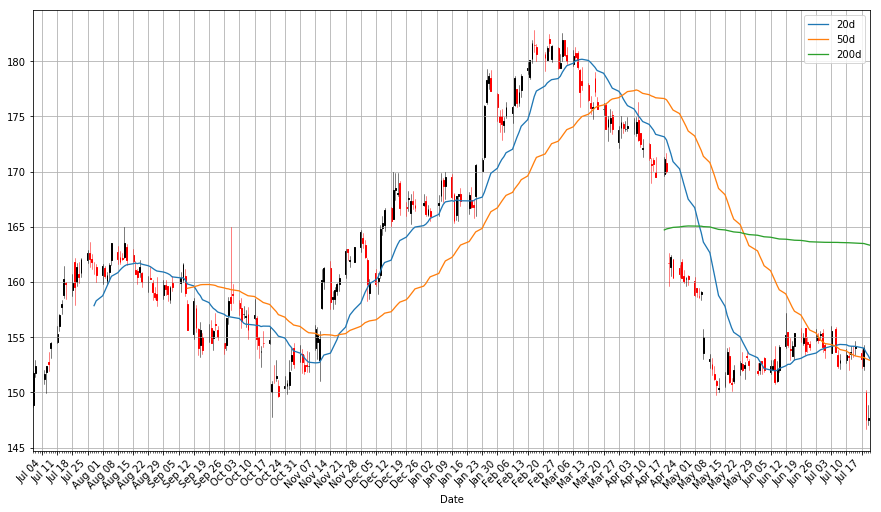

In [43]:
ibm['50d'] = np.round(ibm['Close'].rolling(window = 50, center = False).mean(), 2)
ibm['200d'] = np.round(ibm['Close'].rolling(window = 200, center = False).mean(), 2)

pandas_candlestick_ohlc(ibm.loc['2016-06-30': '2017-07-21', : ], otherseries = ['20d', '50d', '200d'])


The 20-day moving average is the most sensitive to local changes, and the 200-day is the least sensitive. From the chart above, both 20 and 50-day moving average indicate the stock sometimes bullish and sometimes bearish. But the 200-day moving average showing the stock is trending downward and is bearish. 